### PadhAI Contest - Mobile Phone Like/Unlike Classification Using Perceptron Algorithm


> **Data** :- Mobie Dataset from https://www.91mobiles.com/


> **Task** :- To predict Whether users like the mobile phone or not.




**1. Importing Libraries**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
from sklearn import preprocessing
import seaborn as sns
import os
import warnings
import lightgbm as lgb

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4

*Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.*

**2. Loading the train and test dataset.**

In [172]:
# read data from file
train = pd.read_csv("./train.csv") 
test = pd.read_csv("./test.csv")

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [173]:
test.columns

Index(['PhoneId', 'Also Known As', 'Applications', 'Architecture',
       'Aspect Ratio', 'Audio Features', 'Audio Jack', 'Autofocus',
       'Bezel-less display', 'Bluetooth', 'Brand', 'Browser', 'Build Material',
       'Camera Features', 'Capacity', 'Chipset', 'Co-Processor', 'Colours',
       'Custom UI', 'Display Colour', 'Display Type', 'Email',
       'Expandable Memory', 'FM Radio', 'Fingerprint Sensor',
       'Fingerprint Sensor Position', 'Flash', 'GPS', 'Games', 'Graphics',
       'HDMI', 'Heart Rate Monitor', 'Height', 'IRIS Scanner',
       'Image Resolution', 'Internal Memory', 'Java', 'Launch Date',
       'Loudspeaker', 'Mobile High-Definition Link(MHL)', 'Model', 'Music',
       'NFC', 'Network', 'Network Support', 'Operating System',
       'Optical Image Stabilisation', 'Other Facilities', 'Other Sensors',
       'Phone Book', 'Physical Aperture', 'Pixel Density', 'Processor',
       'Quick Charging', 'RAM', 'Rating Count', 'Resolution', 'Review Count',
       'Ring

### Statistics of Dataset:

***Missing values:***

'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447) 'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467), 'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473), 'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456), 'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

***Very low variance:***
'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'

***Multivalued:***
'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

***Not important:***
'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

***Doubtful:***
'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing), 'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'

***To check:***
'Display Type','Expandable Memory','FM Radio'

High Correlation with other features
'SIM Slot(s)' high correlation with SIM1 'Weight' has high high correlation with capacity , screen-to-body ratio 'Height' - screen size is also there

Given a mobile, we can't directly get these features
'Rating Count', 'Review Count'

***Keeping:***
'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',

**3. Data Preprocessing**


> *** 3.1 Functon for removing missing values***

        Purpose:- Removes all the missing value featues from the dataset





In [0]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

In [0]:
train = data_clean(train)
test = data_clean(test)

*Removing all the data point in which more than 15 features are missing*

In [0]:
train = train[(train.isnull().sum(axis=1) <= 15)]

In [177]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


**3.2 Funtction for Data Cleansing**

> *Purpose:- Filing Missing values in the data and type_casting the data(sttring to int).*



In [0]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

In [0]:
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

In [0]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_integer)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    return data

In [0]:
train = data_clean_2(train)
test = data_clean_2(test)

In [182]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


**3.2 Function to remove unimportant features**

> Purpose: Remove those features that are not important.



In [0]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [0]:
train = data_clean_3(train)
test = data_clean_3(test)

In [185]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [0]:
train['Rating']=train['Rating'].apply(lambda x: 1 if x >=THRESHOLD else 0)

**3.3 Data Visualization**

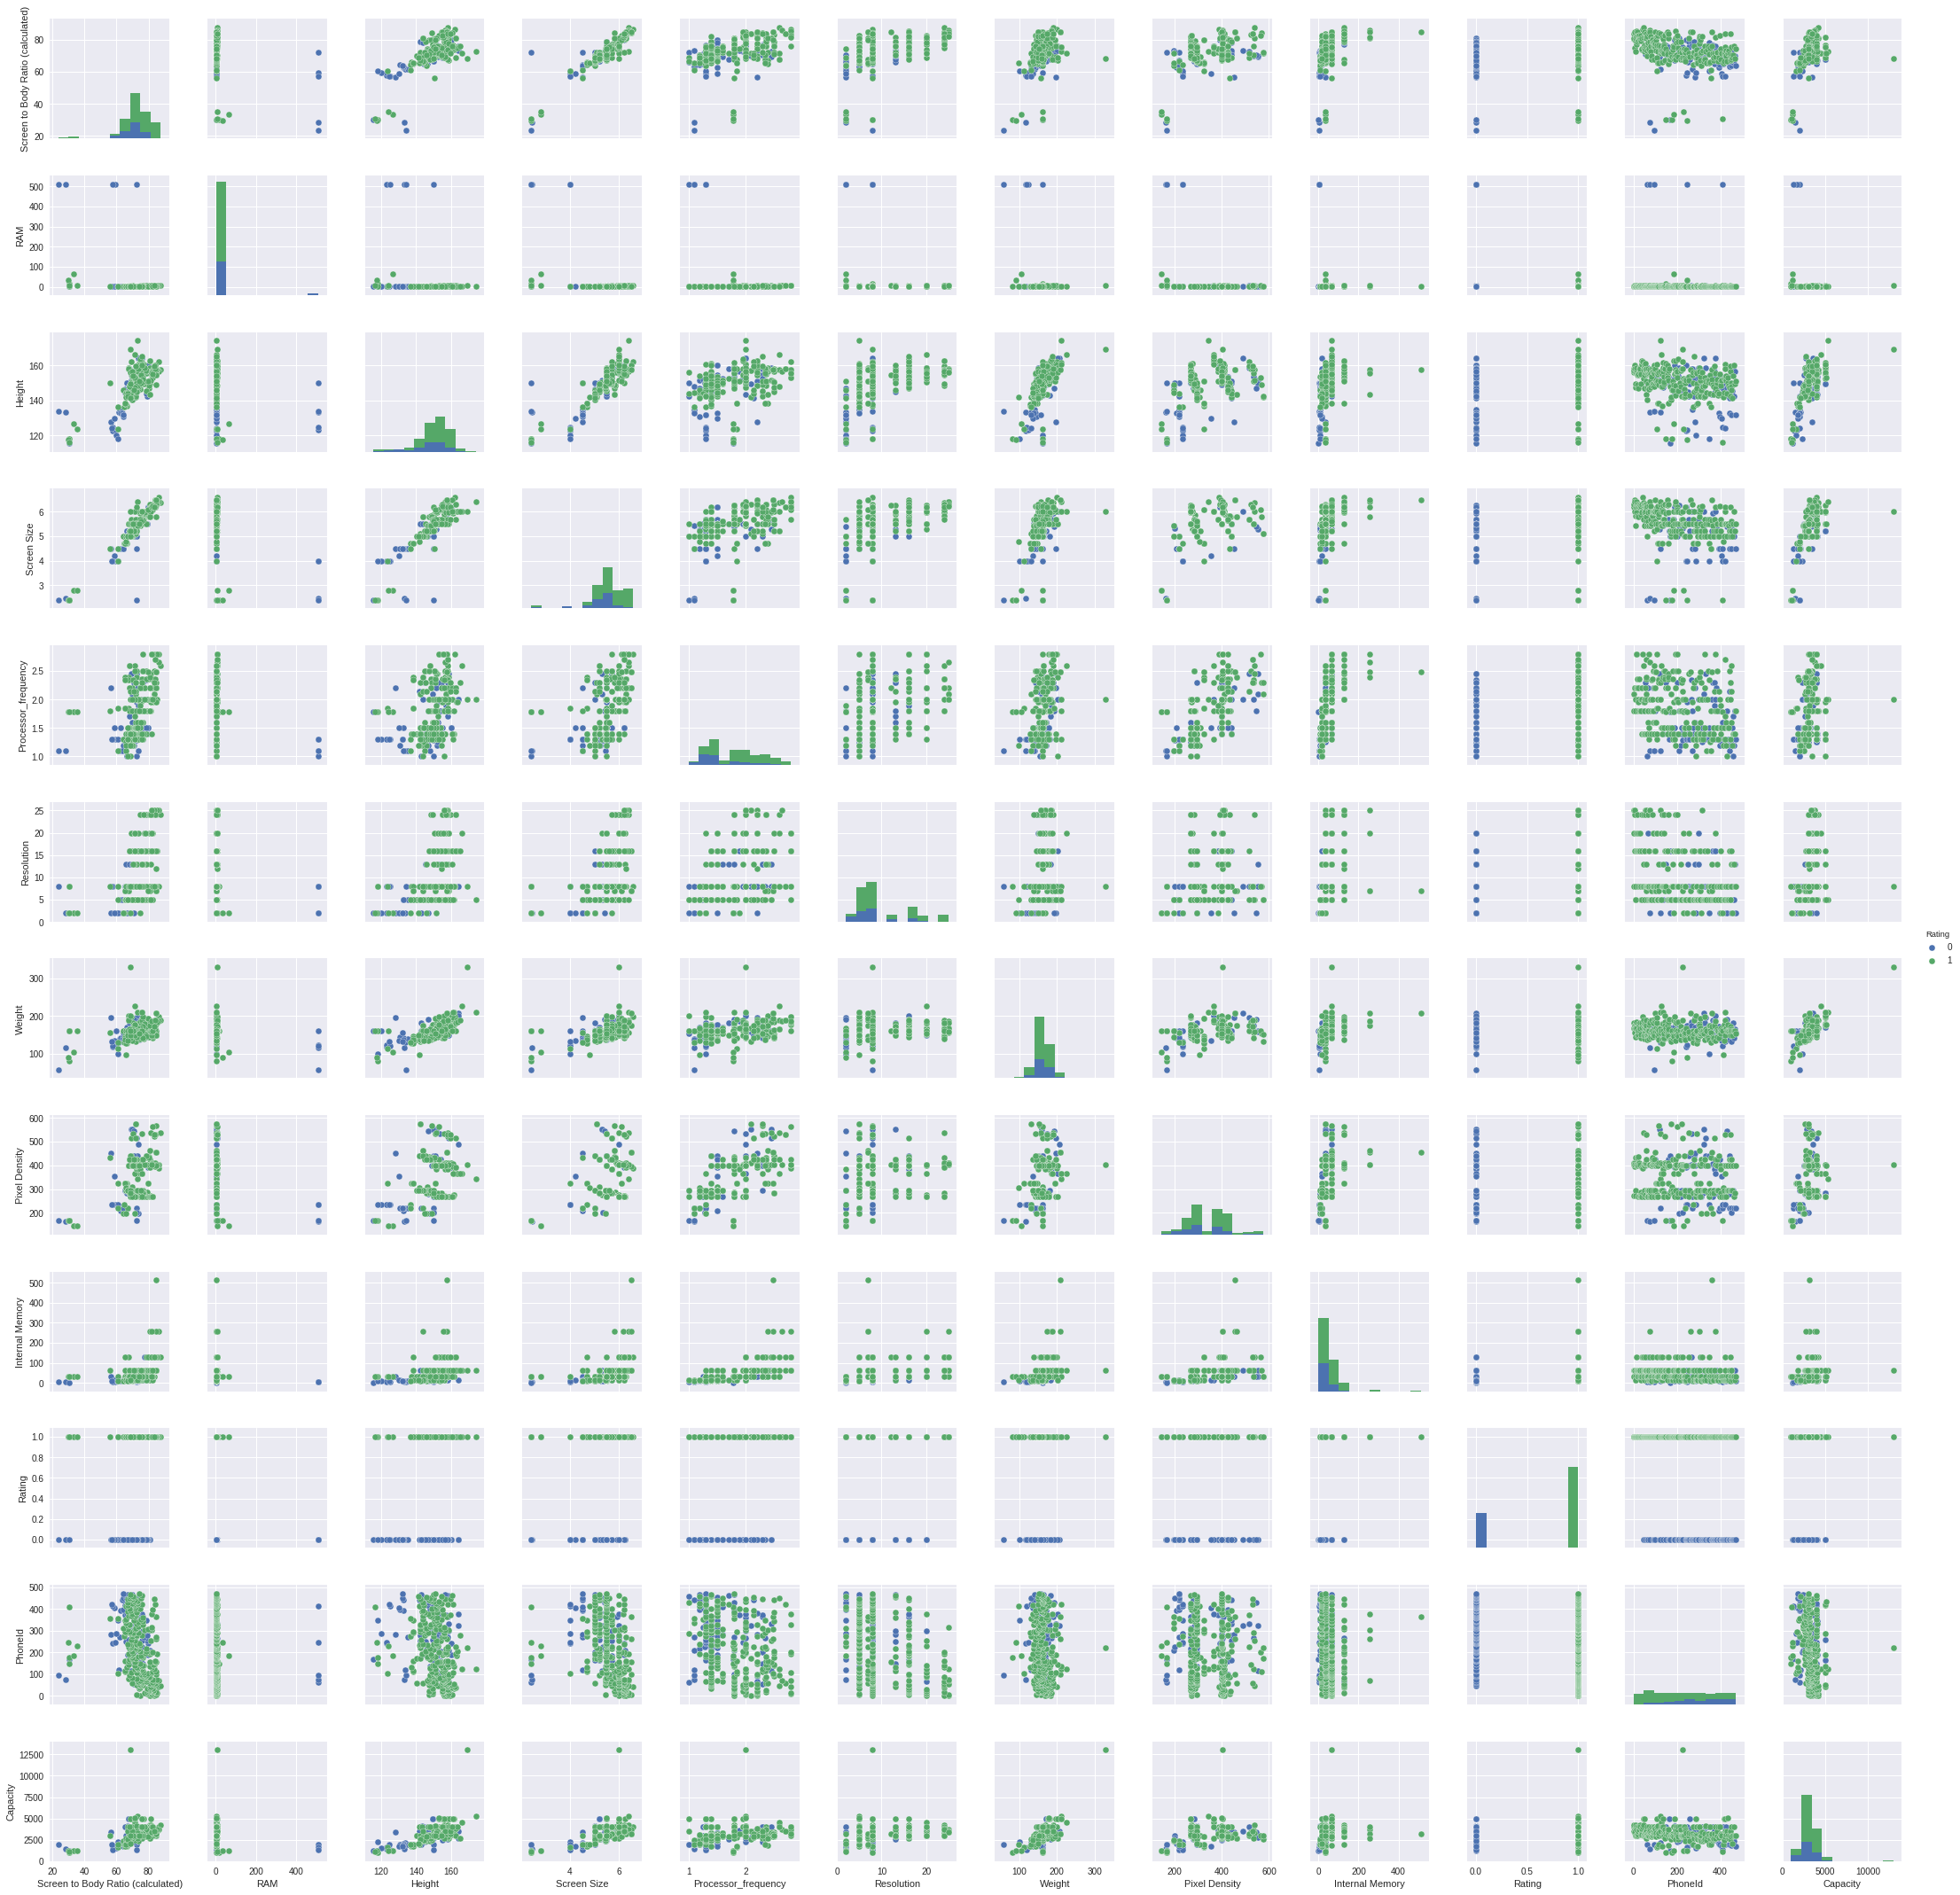

In [187]:
g = sns.pairplot(train, hue="Rating")

Text(0.5, 1.0, 'RAM Size VS Processor_frequency')

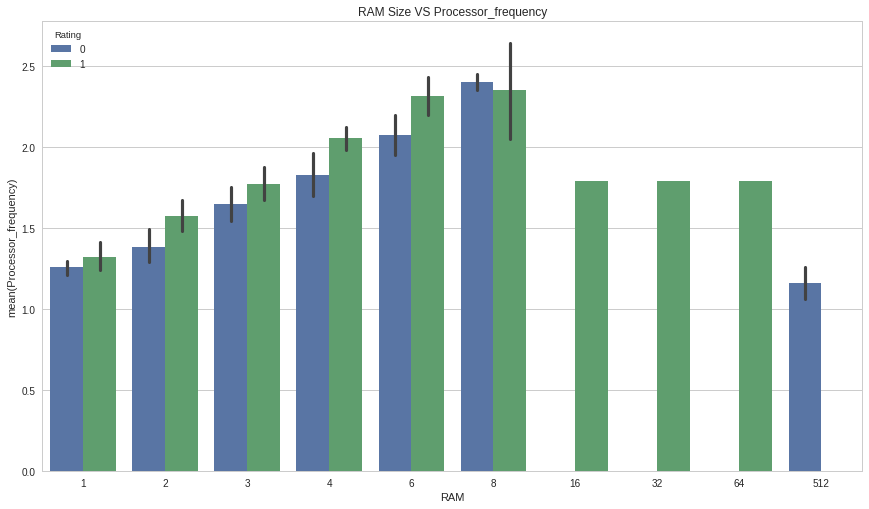

In [188]:
sns.set_style("whitegrid")
plot1 = sns.barplot(x='RAM',y='Processor_frequency',hue='Rating',data=train)
plt.title("RAM Size VS Processor_frequency")

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

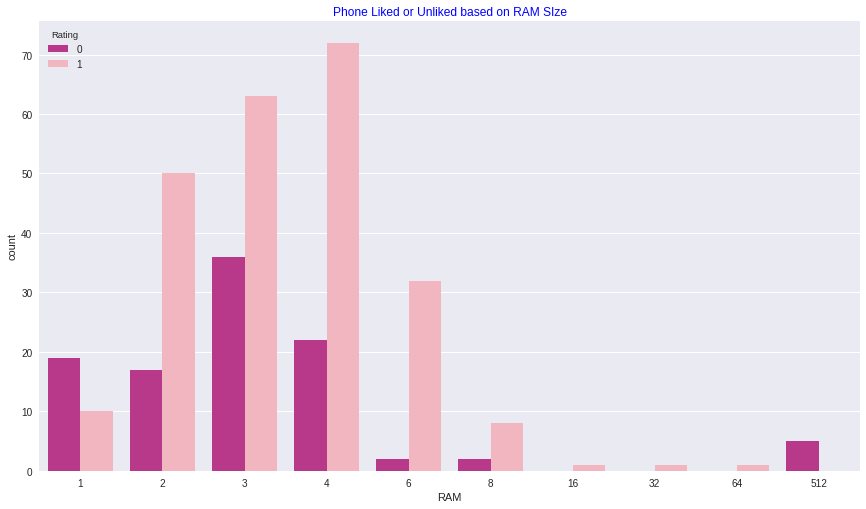

In [189]:

sns.set(rc={'figure.figsize':(14.7,8.27)})
sns.countplot(x="RAM", hue="Rating", data=train, palette='RdPu_r')
plt.title("Phone Liked or Unliked based on RAM SIze",color="b")
plt.xticks(rotation=0)

**The data is correlated to find the highly correlated features.**

**Input: train_data**

output: Heatmap stating correlation among columns

The 'Corr' function is used to find the correlation among the data.

The Top_correlated_features are obtained by finding the Target column having above 40% of correlation

If we have features that are too correlated, we have to remove one, as this may worsen the model. 

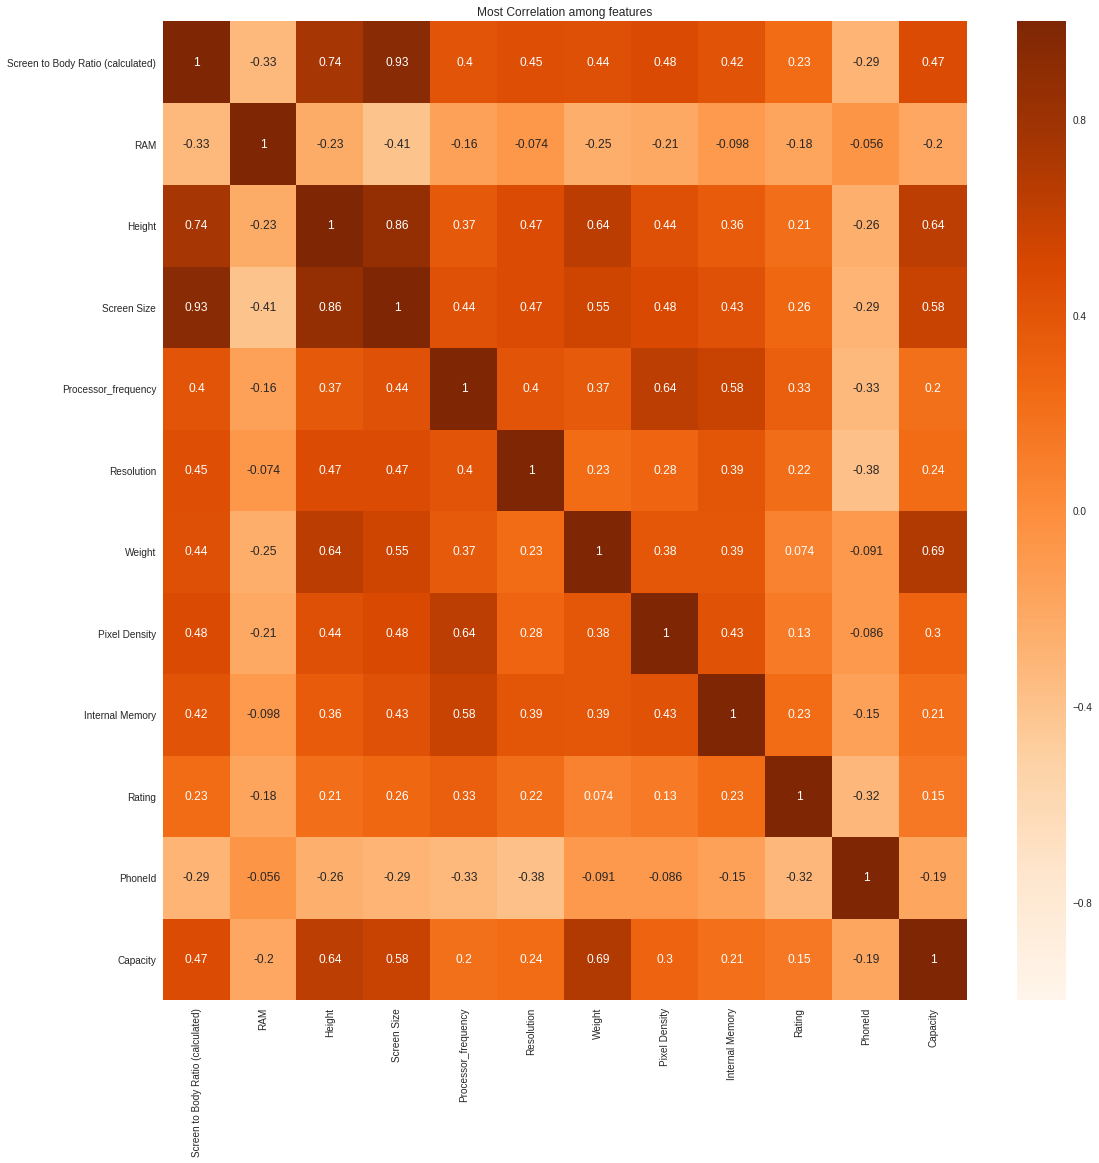

In [190]:
f,ax=plt.subplots(figsize=(18,18))
corrmat=train.corr()
top_corr_features = corrmat.index[abs(corrmat["Rating"])>=0.04]
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap='Oranges').set_title("Most Correlation among features")

**3.4 Function for Data Transformation(OneHotEncoding)**

> Purpose :-  converting categorical data to numerical data only if the there are more than 2 distinct
                     categories in a column.



In [191]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'SIM Slot(s)', 'Screen to Body Ratio (calculated)', 'RAM',
       'Brand', 'Height', 'Screen Size', 'Processor_frequency', 'Resolution',
       'Weight', 'Pixel Density', 'Internal Memory', 'SIM 2', 'os_name',
       'Capacity', 'Sim1', 'Num_cores'],
      dtype='object')
(460, 87)
Index(['PhoneId', 'Screen to Body Ratio (calculated)', 'RAM', 'Height',
       'Screen Size', 'Processor_frequency', 'Resolution', 'Weight',
       'Pixel Density', 'Internal Memory', 'Capacity',
       'SIM Slot(s)_Dual SIM, GSM+CDMA', 'SIM Slot(s)_Dual SIM, GSM+GSM',
       'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE',
       'SIM Slot(s)_Single SIM, GSM', 'Brand_10.or', 'Brand_Apple',
       'Brand_Asus', 'Brand_Billion', 'Brand_Blackberry', 'Brand_Comio',
       'Brand_Coolpad', 'Brand_Do', 'Brand_Gionee', 'Brand_Google',
       'Brand_HTC', 'Brand_Honor', 'Brand_Huawei', 'Brand_InFocus',
       'Brand_Infinix', 'Brand_Intex', 'Brand_Itel', 'Brand_Jivi',
       'Brand_Karbonn',

In [0]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [193]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


**4. Converting Rating column into 1 if the rating column is greather than 4 else 0.**

In [194]:
train_new.groupby('Rating').mean()

,PhoneId,Screen to Body Ratio (calculated),RAM,Height,Screen Size,Processor_frequency,Resolution,Weight,Pixel Density,Internal Memory,...,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa
Rating,,,,,,,,,,,,,,,,,,,,,
0,299.485437,69.088544,27.543689,146.980823,5.163689,1.568447,7.601942,158.84466,327.116505,30.330097,...,0.048544,0.941748,0.000000,0.019417,0.038835,0.009709,0.436893,0.009709,0.485437,0.000000
1,204.184874,73.766261,4.012605,151.229813,5.591555,1.889538,10.453782,162.42437,351.609244,53.310924,...,0.008403,0.966387,0.004202,0.000000,0.025210,0.046218,0.642857,0.021008,0.256303,0.004202


**5. Feature Importance**

> Feature selection algorithms gives us a high level overview of the features that are affecting the statistical model. In other words this gives us relatively the most important features from our dataset.We can use these features for our final model building task without Overfitting(feeding the model with too many features that can inversely affect the model outcome).



**Why LightGbm: **

> 1. lightGBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.


> 2. lightGBM supports both categorical and numerical data (unlike random forest which supports only numerical features or chi-sqare which supports only categorical features). 


> 3. lightGBM is faster than most of the other algorithms(such as Random Forest)



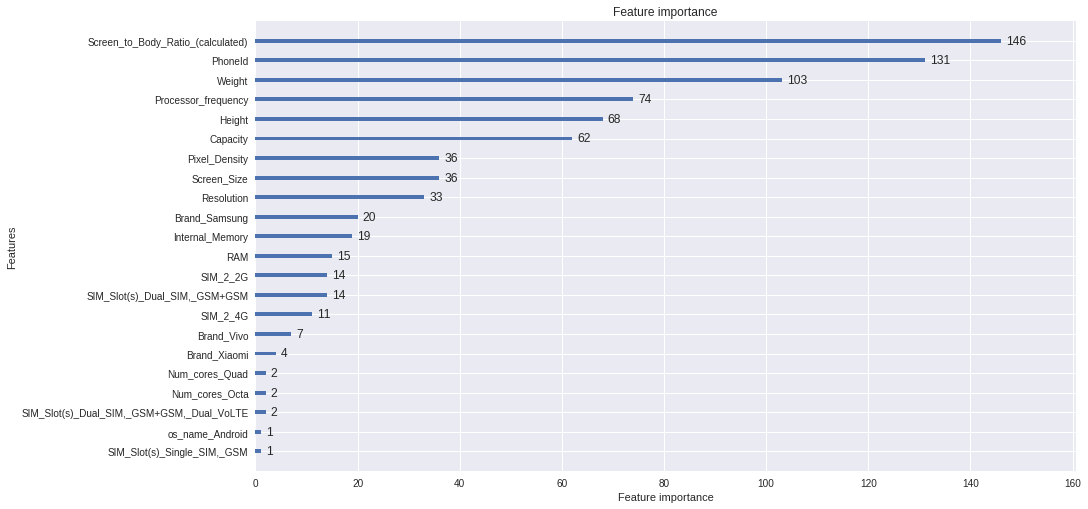

In [195]:
d_train = lgb.Dataset(train_new.drop(['Rating'],axis=1),label=train_new.Rating)
param = {'max_depth':5, 'learning_rate' : 0.1, 'num_leaves': 900, 'n_estimators': 100}
model2 = lgb.train(params=param,train_set=d_train)
ax = lgb.plot_importance(model2, max_num_features=25)
plt.show()


In [0]:
X = train_new.drop(['Rating'],axis=1)
Y = train_new['Rating']

In [0]:
X_test_new = test_new

**6. Converting Training Dataset into training and valuation set using scikit-learn train_test_split fucntion.**

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify = Y, random_state=1)

In [199]:
print(X_train.shape,X_test.shape)

(306, 87) (35, 87)


**6.1 Standardization**

Standardization (or Z-score normalization) is the process of rescaling the features so that they’ll
have the properties of a Gaussian distribution with

μ=0 and σ=1

where μ is the mean and σ is the standard deviation from the mean; standard scores (also called z scores) of the samples are calculated as follows:

$z = (x-μ)/σ$

In [0]:
std_scale = preprocessing.StandardScaler().fit(X)
X_train = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)
X_test_new = std_scale.transform(X_test_new)

### 7.  Model Building using Perceptron Algorithm


> $y = 1, \mbox{if} \sum_i w_i x_i >=b$


> $y = 0. \mbox{otherwise}$







In [0]:
class Perceptron:
  
  def __init__ (self):
    self.w = None
    self.b = None
    
  def model(self, x):
    return 1 if (np.dot(self.w, x) >= self.b) else 0
    
  def predict(self, X):
    Y = []
    for x in X:
      result = self.model(x)
      Y.append(result)
    return np.array(Y)
    
  def fit(self, X, Y, epochs = 1, lr = 1):
    
    self.w = np.ones(X.shape[1])
    self.b = 0
    
    accuracy = {}
    max_accuracy = 0
    
    wt_matrix = []
    
    for i in range(epochs):
      for x, y in zip(X, Y):
        y_pred = self.model(x)
        if y == 1 and y_pred == 0:
          self.w = self.w + lr * x
          self.b = self.b - lr * 1
        elif y == 0 and y_pred == 1:
          self.w = self.w - lr * x
          self.b = self.b + lr * 1
          
      wt_matrix.append(self.w)    
          
      accuracy[i] = accuracy_score(self.predict(X), Y)
      if (accuracy[i] > max_accuracy):
        max_accuracy = accuracy[i]
        chkptw = self.w
        chkptb = self.b
        
    self.w = chkptw
    self.b = chkptb
        
    print(max_accuracy)
    
    plt.plot(accuracy.values())
    plt.ylim([0.6, 1])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.show()
    
    return np.array(wt_matrix)

In [0]:
perceptron = Perceptron()

0.8529411764705882


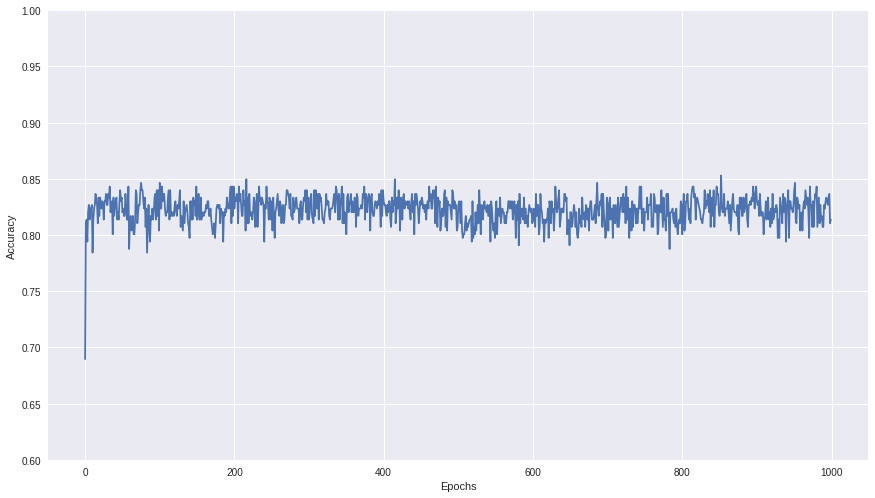

In [203]:
wt_matrix = perceptron.fit(X_train, Y_train,1000,0.02)

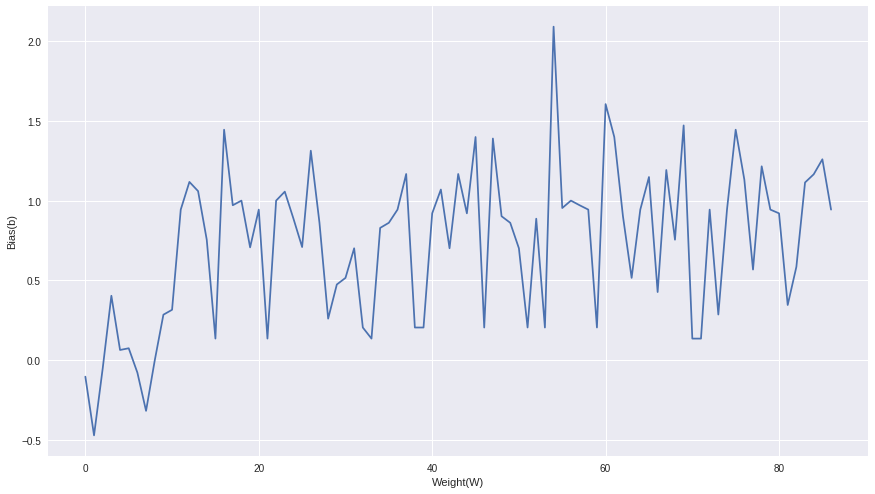

In [204]:
plt.plot(perceptron.w)
plt.xlabel('Weight(W)')
plt.ylabel('Bias(b)')
plt.show()

In [205]:
Y_pred_test = perceptron.predict(X_test_std)
print(accuracy_score(Y_pred_test, Y_test))

0.7142857142857143


In [0]:
Y1_pred_test = perceptron.predict(X_test_new)


In [0]:
submission = pd.DataFrame({'PhoneId':test_new['PhoneId'], 'Class':Y1_pred_test.astype(int)})
submission = submission[['PhoneId', 'Class']]

**7. saving the predictions result on test data corresponding to the PhoneId in csv file**

In [0]:
submission.to_csv("submission.csv", index=False)

**-- End of Notebook**